## import & load

In [186]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [187]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [188]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [595]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [994]:
date_str_from='2024-04-14'
date_str_to='2024-04-30'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [995]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [996]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

185

## calculate/cache feature

In [1013]:
import algo.feature.momentum.calculate
importlib.reload(algo.feature.momentum.calculate)
import algo.feature.momentum.research
importlib.reload(algo.feature.momentum.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/Users/junlim/projects/jitter_recovery/algo/cache.py'>

In [1074]:
feature_param = algo.feature.momentum.calculate.MomentumFeatureParam(window=360, ema_window=60)

In [1075]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(360)_ema_window(60)'

In [1067]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.momentum.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09')

In [1040]:
algo.feature.momentum.research.get_feature_label_for_caching(feature_param)

'feature/(momentum)_window(180)_ema_window(30)'

In [1041]:
dfst_feature.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume', 'value', 'ema', 'ch',
       'ch_ema', 'momentum', 'rank', 'rank_descending'],
      dtype='object')

## multiple symbols

In [1076]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [1077]:
trading_param = algo.alpha.momentum.calculate.MomentumTradingParam(
    feature_param, selection_size=2, rebalance_interval_minutes=6*60)

In [1078]:
algo.alpha.momentum.research.get_trading_label_for_caching(trading_param)

'trading/(momentum_trading)_feature_param(window(360)_ema_window(60))_selection_size(2)_rebalance_interval_minutes(360)'

In [1079]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-04-01', 
    date_str_to='2024-05-09',
    columns=['profit', 'value', 'position_changed']
)

In [ ]:
dfst_trading = algo.alpha.momentum.research.get_dfst_trading(dfst_feature, trading_param)

symbol_with_momentums: 156
0 symbol: ACE-USDT-SWAP: (trading)
1 symbol: ACH-USDT-SWAP: (trading)
2 symbol: ADA-USDT-SWAP: (trading)
3 symbol: AEVO-USDT-SWAP: (trading)
4 symbol: AGIX-USDT-SWAP: (trading)
5 symbol: AIDOGE-USDT-SWAP: (trading)
6 symbol: APT-USDT-SWAP: (trading)
7 symbol: AR-USDT-SWAP: (trading)
8 symbol: AVAX-USDT-SWAP: (trading)
9 symbol: BCH-USDT-SWAP: (trading)
10 symbol: BIGTIME-USDT-SWAP: (trading)
11 symbol: BONK-USDT-SWAP: (trading)
12 symbol: BSV-USDT-SWAP: (trading)
13 symbol: CEL-USDT-SWAP: (trading)
14 symbol: CRO-USDT-SWAP: (trading)
15 symbol: CSPR-USDT-SWAP: (trading)
16 symbol: CVC-USDT-SWAP: (trading)
17 symbol: DMAIL-USDT-SWAP: (trading)
18 symbol: DOGE-USDT-SWAP: (trading)
19 symbol: FET-USDT-SWAP: (trading)
20 symbol: FITFI-USDT-SWAP: (trading)
21 symbol: FLM-USDT-SWAP: (trading)
22 symbol: FLOKI-USDT-SWAP: (trading)
23 symbol: FRONT-USDT-SWAP: (trading)
24 symbol: FTM-USDT-SWAP: (trading)
25 symbol: GAS-USDT-SWAP: (trading)
26 symbol: GPT-USDT-SWAP: (

In [1080]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

1009

<AxesSubplot:xlabel='timestamp'>

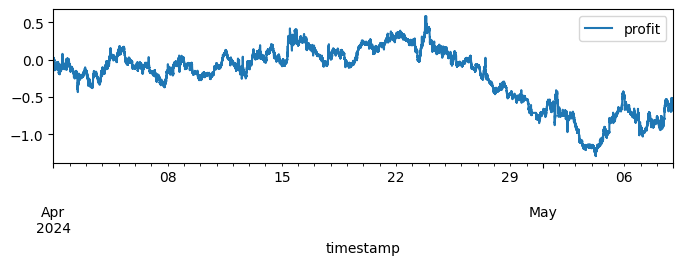

In [1081]:
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1056]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

1970

<AxesSubplot:xlabel='timestamp'>

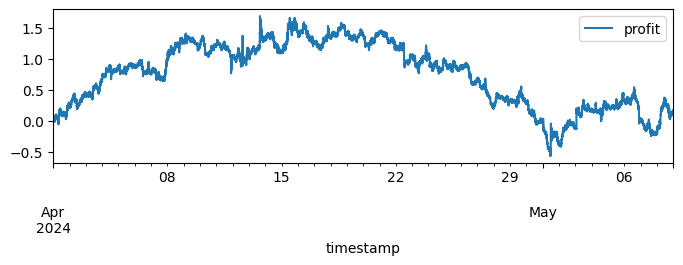

In [1057]:
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1082]:
dfst_trading = algo.cache.read_df(
    label = algo.alpha.momentum.research.get_trading_label_for_caching(trading_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-03', 
    date_str_to='2024-03-31',
    columns=['profit', 'value', 'position_changed']
)

In [1083]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

752

<AxesSubplot:xlabel='timestamp'>

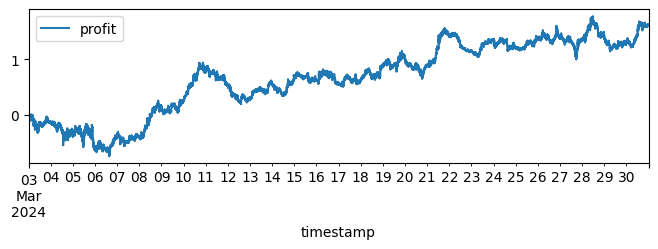

In [1084]:
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1052]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

1480

<AxesSubplot:xlabel='timestamp'>

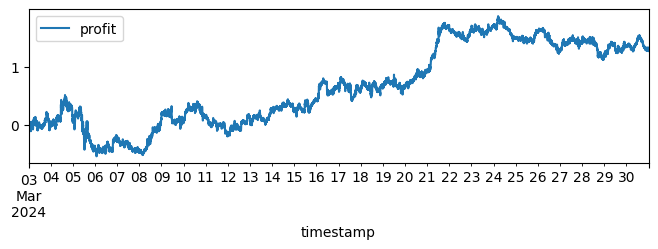

In [1053]:
dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [1058]:
dfst_trading[
    dfst_trading.in_position == 1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

AttributeError: 'DataFrame' object has no attribute 'in_position'

<AxesSubplot:xlabel='timestamp'>

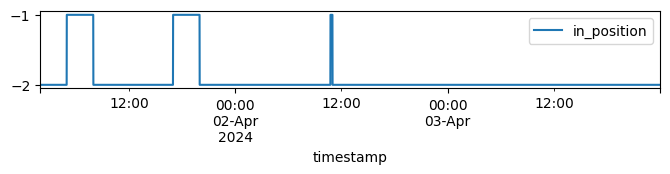

In [981]:
dfst_trading[
    dfst_trading.in_position == -1
][['in_position']].groupby('timestamp').sum().plot(figsize=(8,1))

<AxesSubplot:xlabel='timestamp'>

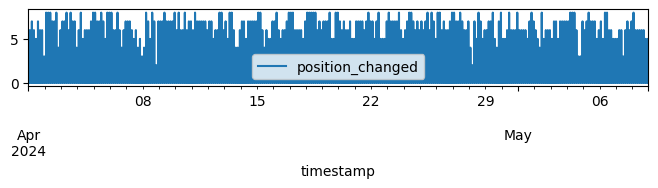

In [1060]:
dfst_trading[['position_changed']].abs().groupby('timestamp').sum().plot(figsize=(8,1))

In [1061]:
dfst_trading.columns

Index(['profit', 'value', 'position_changed'], dtype='object')

In [1062]:
len(dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit'))

147

In [1063]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
FOXY-USDT-SWAP,-0.500616
VELO-USDT-SWAP,-0.345961
ZERO-USDT-SWAP,-0.259117
LSK-USDT-SWAP,-0.233873
MSN-USDT-SWAP,-0.230224
...,...
W-USDT-SWAP,0.260755
ZEUS-USDT-SWAP,0.324602
CEL-USDT-SWAP,0.336206


In [985]:
len(dfst_trading[(dfst_trading.position_changed != 0)].dropna())

164

In [986]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 02:00:00-04:00, JOE-USDT-SWAP, 0.843, position_changed: -1.0
2024-04-01 02:00:00-04:00, LQTY-USDT-SWAP, 2.003, position_changed: 1.0
2024-04-01 02:00:00-04:00, RAY-USDT-SWAP, 2.2908, position_changed: -1.0
2024-04-01 02:00:00-04:00, RVN-USDT-SWAP, 0.05145, position_changed: 1.0
2024-04-01 04:21:00-04:00, RVN-USDT-SWAP, 0.04754, position_changed: -1.0
2024-04-01 05:00:00-04:00, JOE-USDT-SWAP, 0.8753, position_changed: 1.0
2024-04-01 05:00:00-04:00, CORE-USDT-SWAP, 2.6991, position_changed: 1.0
2024-04-01 05:00:00-04:00, RAY-USDT-SWAP, 2.3258, position_changed: 1.0
2024-04-01 05:00:00-04:00, RVN-USDT-SWAP, 0.04778, position_changed: -1.0
2024-04-01 05:00:00-04:00, LQTY-USDT-SWAP, 1.88, position_changed: -1.0
2024-04-01 05:00:00-04:00, DGB-USDT-SWAP, 0.020195, position_changed: 1.0
2024-04-01 07:47:00-04:00, DGB-USDT-SWAP, 0.018109, position_changed: -1.0
2024-04-01 08:00:00-04:00, DGB-USDT-SWAP, 0.018132, position_changed: -1.0
2024-04-01 08:00:00-04:00, SUI-USDT-SWAP, 1.966, 

## single symbol

In [1064]:
import algo.alpha.momentum.calculate
importlib.reload(algo.alpha.momentum.calculate)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)
import algo.alpha.momentum.research
importlib.reload(algo.alpha.momentum.research)

<module 'algo.alpha.momentum.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/momentum/research.py'>

In [1071]:
symbol_investigate = 'SATS-USDT-SWAP'

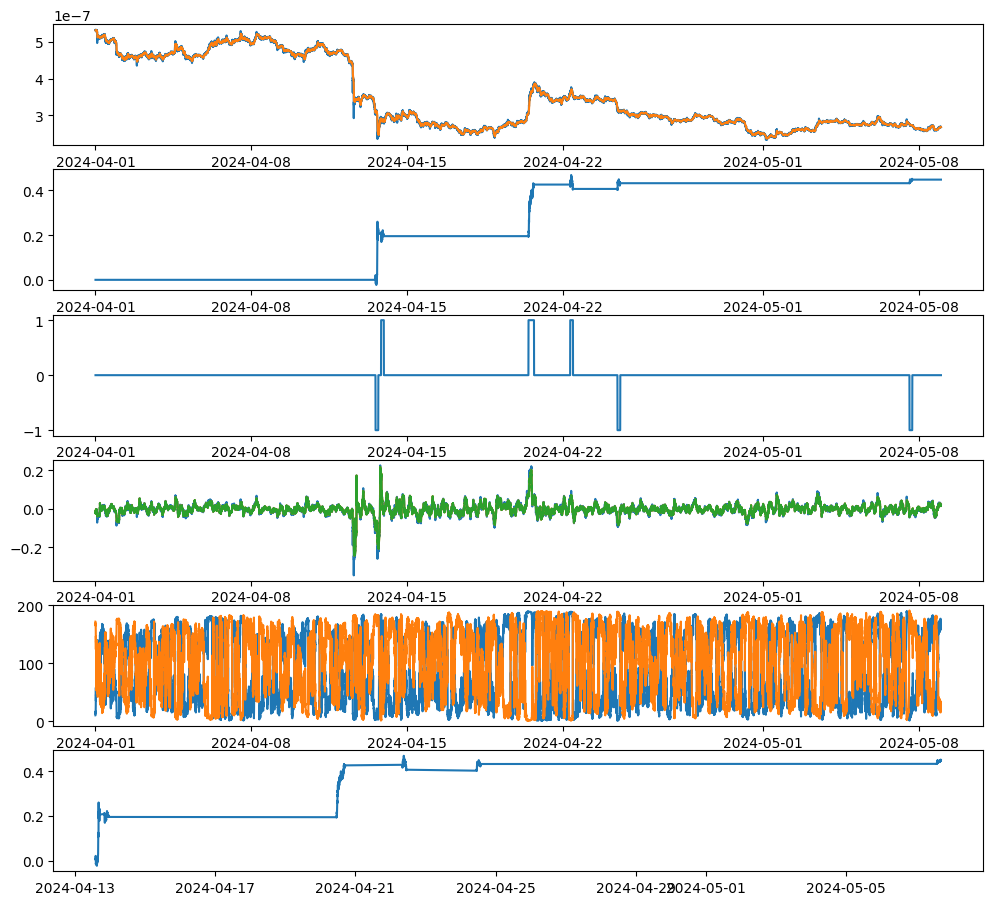

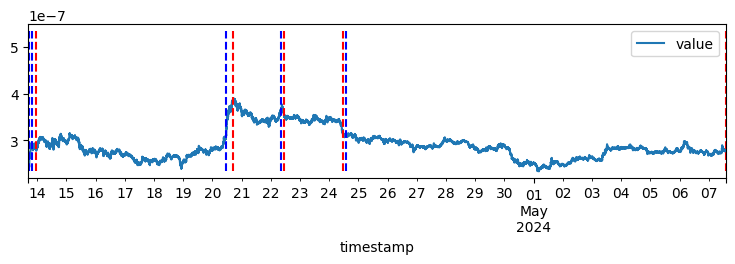

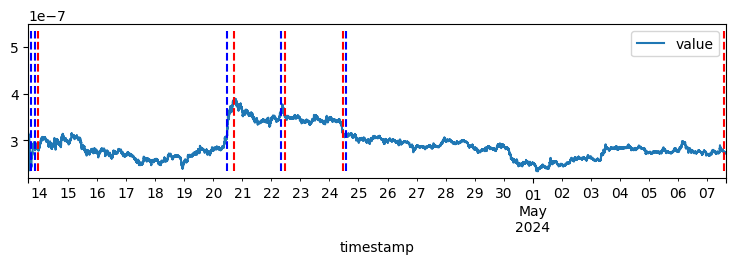

In [1072]:
df_feature, df_trading = algo.alpha.momentum.research.investigate_symbol(
    dfst_feature, symbol_investigate, trading_param, figsize=(12, 11))

In [1073]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-04-13 14:00:00-04:00,3.084000e-07,-1,-1.0,0.000000e+00,0.000000
2024-04-13 17:00:00-04:00,2.483800e-07,0,1.0,-3.470000e-09,-0.014168
2024-04-13 20:00:00-04:00,2.893200e-07,1,1.0,-0.000000e+00,-0.000000
2024-04-13 23:00:00-04:00,2.859100e-07,0,-1.0,-7.000000e-10,-0.002442
2024-04-20 11:00:00-04:00,3.055400e-07,1,1.0,-0.000000e+00,-0.000000
2024-04-20 17:00:00-04:00,3.830600e-07,0,-1.0,-1.200000e-10,-0.000313
2024-04-22 08:00:00-04:00,3.613100e-07,1,1.0,-0.000000e+00,-0.000000
2024-04-22 11:00:00-04:00,3.540000e-07,0,-1.0,1.300000e-10,0.000367
2024-04-24 11:00:00-04:00,3.203400e-07,-1,-1.0,-0.000000e+00,-0.000000


In [941]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-01 23:00:00-04:00, AEVO-USDT-SWAP, 3.114, position_changed: 1.0
2024-04-02 02:00:00-04:00, AEVO-USDT-SWAP, 3.023, position_changed: -1.0
2024-04-02 08:00:00-04:00, AEVO-USDT-SWAP, 2.883, position_changed: -1.0
2024-04-02 11:00:00-04:00, AEVO-USDT-SWAP, 3.168, position_changed: 1.0
2024-04-03 08:00:00-04:00, AEVO-USDT-SWAP, 3.069, position_changed: -1.0
2024-04-03 11:00:00-04:00, AEVO-USDT-SWAP, 3.047, position_changed: 1.0
